**Dependencies and setup**

This can take a minute or so...

In [1]:

!pip install setuptools==65.5.0 "wheel<0.40.0"
!apt update
!apt-get install python3-opengl
!apt install xvfb -y
!pip install 'swig'
!pip install 'pyglet==1.5.27'
!pip install 'gym[box2d]==0.20.0'
!pip install 'pyvirtualdisplay==3.0'

Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [8]:
import sys
sys.path.append('/home2/wgmd33/.local/lib/python3.8/site-packages')

In [11]:
!pip install pytorch

     |████████████████████████████████| 779.1 MB 13 kB/s s eta 0:00:01     |████████████▍                   | 301.0 MB 76.3 MB/s eta 0:00:07     |██████████████████▉             | 459.7 MB 84.6 MB/s eta 0:00:04     |███████████████████             | 461.8 MB 84.6 MB/s eta 0:00:04     |███████████████████▏            | 468.0 MB 84.6 MB/s eta 0:00:04     |███████████████████▍            | 472.1 MB 24.1 MB/s eta 0:00:13     |███████████████████▋            | 476.3 MB 24.1 MB/s eta 0:00:13     |███████████████████▊            | 480.4 MB 24.1 MB/s eta 0:00:13     |████████████████████▉           | 507.1 MB 24.1 MB/s eta 0:00:12     |██████████████████████▍         | 545.5 MB 43.5 MB/s eta 0:00:06     |██████████████████████▌         | 547.5 MB 43.5 MB/s eta 0:00:06     |██████████████████████▉         | 555.4 MB 39.2 MB/s eta 0:00:06     |███████████████████████▉        | 581.6 MB 39.2 MB/s eta 0:00:06     |████████████████████████▏       | 589.5 MB 48.7 MB/s eta 0:00:04
  Using cached symp

In [1]:
import gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import sys
from pyvirtualdisplay import Display
from IPython import display as disp
%matplotlib inline

display = Display(visible=0,size=(600,600))
display.start()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

plot_interval = 10 # update the plot every N episodes
video_every = 100 # videos can take a very long time to render so only do it every N episodes

**Reinforcement learning agent**

Replace this with your own agent - I recommend starting with TD3 (lecture 8)

In [2]:
import copy

In [3]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)
    
    def __len__(self):
        return len(self.buffer)

class SACAgent(nn.Module):
    def __init__(self, obs_dim, act_dim, learning_rate=3e-4):
        super(SACAgent, self).__init__()
        self.act_dim = act_dim
        self.gamma = 0.99  # Discount factor
        self.soft_tau = 1e-2  # Soft update parameter

        # Actor network
        # Adding dropout might help generalize better in complex environments
        self.actor = nn.Sequential(
            nn.Linear(obs_dim, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, act_dim),
            nn.Tanh()
        )


        # Critic network
        self.critic = nn.Sequential(
            nn.Linear(obs_dim + act_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        # Second critic network
        self.critic2 = nn.Sequential(
            nn.Linear(obs_dim + act_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        # Target Critic networks
        self.critic_target = copy.deepcopy(self.critic)
        self.critic2_target = copy.deepcopy(self.critic2)

        # Optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=learning_rate)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=learning_rate)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def get_action(self, state):
        state = torch.FloatTensor(state).to(self.device)
        action = self.actor(state).detach().cpu().numpy()
        return action

    def update(self, replay_buffer, batch_size):
        state, action, reward, next_state, done = replay_buffer.sample(batch_size)

        state = torch.FloatTensor(state).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        action = torch.FloatTensor(action).to(self.device)
        reward = torch.FloatTensor(reward).to(self.device).unsqueeze(1)
        done = torch.FloatTensor(np.float32(done)).to(self.device).unsqueeze(1)

        with torch.no_grad():
            next_action = self.actor(next_state)
            next_q_value = torch.min(
                self.critic_target(torch.cat([next_state, next_action], 1)),
                self.critic2_target(torch.cat([next_state, next_action], 1))
            )
            target_q_value = reward + (1 - done) * self.gamma * next_q_value

        q_value = self.critic(torch.cat([state, action], 1))
        q_value2 = self.critic2(torch.cat([state, action], 1))

        critic_loss = F.mse_loss(q_value, target_q_value.detach()) + F.mse_loss(q_value2, target_q_value.detach())
        self.critic_optimizer.zero_grad()
        self.critic2_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        self.critic2_optimizer.step()

        actor_loss = -(self.critic(torch.cat([state, self.actor(state)], 1))).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft update of target networks
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.soft_tau) + param.data * self.soft_tau)

        for target_param, param in zip(self.critic2_target.parameters(), self.critic2.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.soft_tau) + param.data * self.soft_tau)



**Prepare the environment and wrap it to capture videos**

In [4]:
%%capture
env = gym.make("BipedalWalker-v3")
# env = gym.make("BipedalWalkerHardcore-v3") # only attempt this when your agent has solved BipedalWalker-v3
env = gym.wrappers.Monitor(env, "./video", video_callable=lambda ep_id: ep_id%video_every == 0, force=True)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

In [5]:
print('The environment has {} observations and the agent can take {} actions'.format(obs_dim, act_dim))
print('The device is: {}'.format(device))

if device.type != 'cpu': print('It\'s recommended to train on the cpu for this')

The environment has 24 observations and the agent can take 4 actions
The device is: cuda
It's recommended to train on the cpu for this


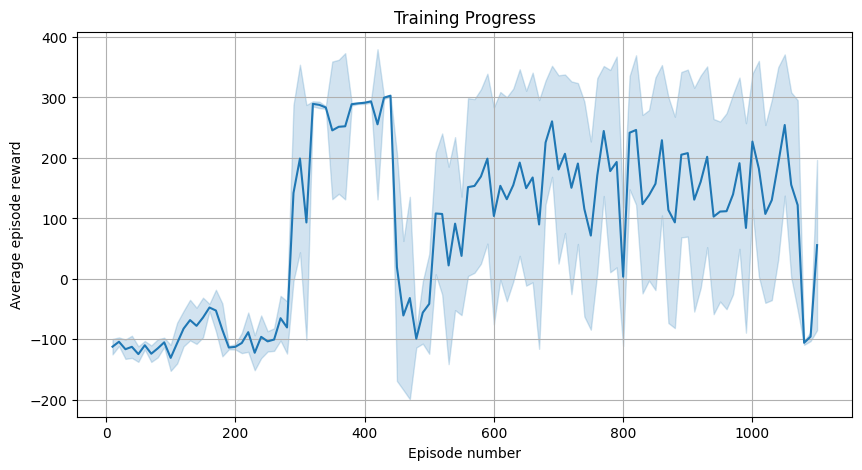

In [ ]:
# Set up the seed for reproducibility
seed = 42
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)

# Initialize logging variables
ep_reward = 0
reward_list = []
plot_data = []
log_f = open("agent-log.txt", "w+")

# Initialize the SAC agent and replay buffer
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
sac_agent = SACAgent(obs_dim=obs_dim, act_dim=act_dim)
replay_buffer = ReplayBuffer(capacity=10000)

#max_episodes = 100
max_episodes = 2000
max_timesteps = 2000
batch_size = 64

# Training procedure
for episode in range(1, max_episodes + 1):
    state = env.reset()
    ep_reward = 0

    for t in range(max_timesteps):
        # Select the agent action using SAC policy
        action = sac_agent.get_action(state)

        # Take action in the environment and get result
        next_state, reward, done, _ = env.step(action)
        ep_reward += reward

        # Store the transition in the replay buffer
        replay_buffer.push(state, action, reward, next_state, done)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization if the buffer has enough samples
        if len(replay_buffer) > batch_size:
            sac_agent.update(replay_buffer, batch_size)

        # Check if the episode is done
        if done or t == (max_timesteps - 1):
            break

    # Append the episode reward to the reward list
    reward_list.append(ep_reward)

    # Do NOT change this logging code - it is used for automated marking
    log_f.write('episode: {}, reward: {}\n'.format(episode, ep_reward))
    log_f.flush()

    # Plot reward data every so often
    if episode % plot_interval == 0:
        plot_data.append([episode, np.array(reward_list).mean(), np.array(reward_list).std()])
        reward_list = []
        plt.figure(figsize=(10, 5))
        plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:blue')
        plt.fill_between([x[0] for x in plot_data], [x[1] - x[2] for x in plot_data], [x[1] + x[2] for x in plot_data], color='tab:blue', alpha=0.2)
        plt.title('Training Progress')
        plt.xlabel('Episode number')
        plt.ylabel('Average episode reward')
        plt.grid(True)
        plt.show()
        disp.clear_output(wait=True)
